#**AZATIK BATIK MOTIF CLASSIFICATION**

## Load Dataset

In [1]:
#connecting to collab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#unzipping dataset
!unzip gdrive/My\ Drive/data/Azatik-Dataset3.zip

Archive:  gdrive/My Drive/data/Azatik-Dataset3.zip
   creating: Azatik-Dataset/
   creating: Azatik-Dataset/Celup/
  inflating: Azatik-Dataset/Celup/1.jpg  
  inflating: Azatik-Dataset/Celup/10.jpg  
  inflating: Azatik-Dataset/Celup/11.jpg  
  inflating: Azatik-Dataset/Celup/12.jpg  
  inflating: Azatik-Dataset/Celup/13.jpg  
  inflating: Azatik-Dataset/Celup/14.jpg  
  inflating: Azatik-Dataset/Celup/15.jpg  
  inflating: Azatik-Dataset/Celup/16.jpg  
  inflating: Azatik-Dataset/Celup/17.jpg  
  inflating: Azatik-Dataset/Celup/18.jpg  
  inflating: Azatik-Dataset/Celup/19.jpg  
  inflating: Azatik-Dataset/Celup/2.jpg  
  inflating: Azatik-Dataset/Celup/20.jpg  
  inflating: Azatik-Dataset/Celup/21.jpg  
  inflating: Azatik-Dataset/Celup/22.jpg  
  inflating: Azatik-Dataset/Celup/23.jpg  
  inflating: Azatik-Dataset/Celup/24.jpg  
  inflating: Azatik-Dataset/Celup/25.jpg  
  inflating: Azatik-Dataset/Celup/26.jpg  
  inflating: Azatik-Dataset/Celup/27.jpg  
  inflating: Azatik-Dataset

## Splitting Dataset

In [18]:
!rm -rf traintestval

In [19]:
#import library
import os
import random
import numpy as np
import tensorflow as tf
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
import imghdr
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow.compat.v1.keras.backend import backend as K
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras_preprocessing import image
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model

In [20]:
#source path folder to dataset and making labels
source_path = 'Azatik-Dataset/' 
labels = ['Tambal', 'Parang','Kawung','Celup', 'Cendrawasih']

#the split ratio
val_ratio = 0.1
test_ratio = 0.1

#path to directory
root_path = 'traintestval/'

#make directory for split dataset
os.makedirs('traintestval')
os.makedirs(os.path.join(root_path, 'training'))
os.makedirs(os.path.join(root_path, 'testing'))
os.makedirs(os.path.join(root_path, 'validation'))

#path to dataset after split
train_path = 'traintestval/training/'
test_path = 'traintestval/testing/'
val_path = 'traintestval/validation/'

#assigning label
for label in labels:
    os.makedirs(os.path.join(train_path, label))
    os.makedirs(os.path.join(test_path, label))
    os.makedirs(os.path.join(val_path, label))

#Splitting the dataset
    src = source_path + label 
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
          shutil.copy(name, train_path + label)

    for name in val_FileNames:
          shutil.copy(name, val_path + label)

    for name in test_FileNames:
          shutil.copy(name, test_path + label)

In [21]:
#Image Augmentation
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Image augmentation using ImageDataGenerator
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=10, 
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Rescaling
  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=10, 
                                                                class_mode='categorical',
                                                                target_size=(150, 150),
                                                                shuffle=True)
  return train_generator, validation_generator

In [22]:
#checking class and number of image
train_dir = train_path
validation_dir = val_path 
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 399 images belonging to 5 classes.
Found 49 images belonging to 5 classes.


In [23]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))

Found 399 files belonging to 5 classes.


In [24]:
class_names = train_dataset.class_names

print(class_names)

['Celup', 'Cendrawasih', 'Kawung', 'Parang', 'Tambal']


In [25]:
#checking file type
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

#making sure its accepted by tensorflow
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(source_path).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

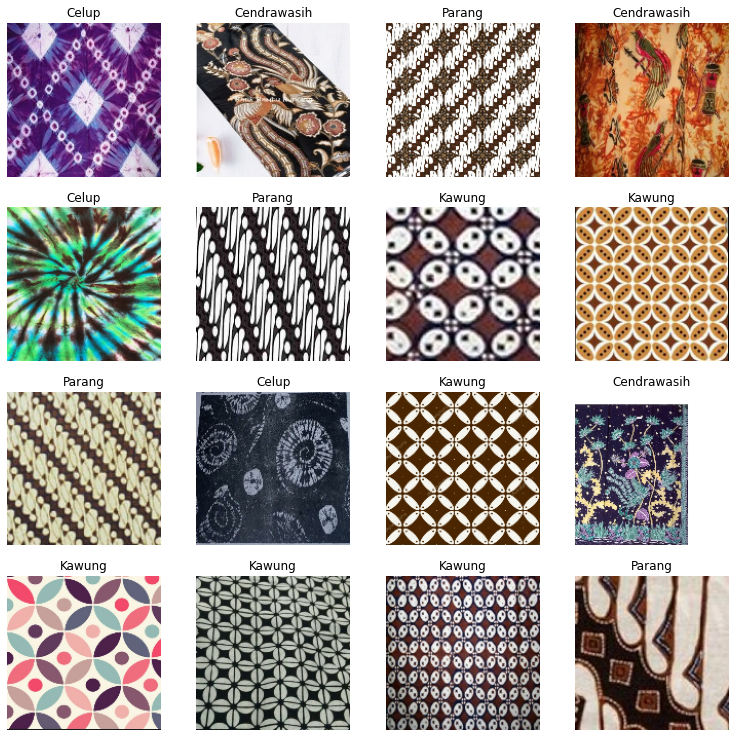

In [26]:
#visualize the dataset
plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Simple CNN

In [27]:
#Making simple CNN model layer
def create_model():
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (3,3),activation ='relu', input_shape = (150,150,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(512, Activation('relu')))

  model.add(Dropout(0.01))
  model.add(Dense(5, activation = "softmax"))

  model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [28]:
#creating the model
model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_98 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 128)     

In [29]:
#Training the model
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
40/40 [==============================] - 24s 577ms/step - loss: 1.6206 - accuracy: 0.2256 - val_loss: 1.5610 - val_accuracy: 0.2449
Epoch 2/20
40/40 [==============================] - 21s 529ms/step - loss: 1.4703 - accuracy: 0.3283 - val_loss: 1.5169 - val_accuracy: 0.2857
Epoch 3/20
40/40 [==============================] - 21s 526ms/step - loss: 1.4138 - accuracy: 0.3684 - val_loss: 1.4138 - val_accuracy: 0.3061
Epoch 4/20
40/40 [==============================] - 21s 529ms/step - loss: 1.3381 - accuracy: 0.4085 - val_loss: 1.3817 - val_accuracy: 0.4082
Epoch 5/20
40/40 [==============================] - 21s 534ms/step - loss: 1.2735 - accuracy: 0.4436 - val_loss: 1.3144 - val_accuracy: 0.4694
Epoch 6/20
40/40 [==============================] - 21s 535ms/step - loss: 1.1942 - accuracy: 0.5088 - val_loss: 1.2913 - val_accuracy: 0.4898
Epoch 7/20
40/40 [==============================] - 21s 534ms/step - loss: 1.1811 - accuracy: 0.5138 - val_loss: 1.5354 - val_accuracy: 0.3469

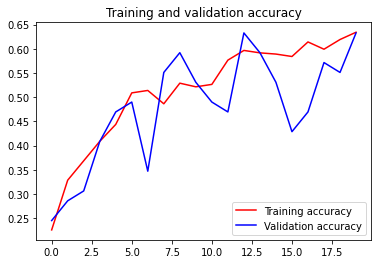

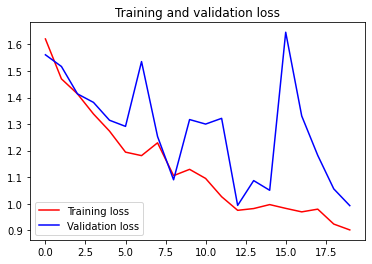

In [30]:
#making graph of result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras_preprocessing import image
from shutil import copyfile
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input
from keras_preprocessing import image
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import os

## w/Transfer Learning InceptionV3

In [32]:
#Downloading and making the model
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


In [33]:
# Freezing the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [34]:
#output shape
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [35]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.01)(x)                  
x = layers.Dense(5, activation='softmax')(x)


In [36]:
model2 = Model(pre_trained_model.input, x)

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_100[0][0]']             
 ormalization)                                                                                    
                                                                                            

In [37]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
history = model2.fit(train_generator, 
                     epochs=25,
                     validation_data=validation_generator, 
                     validation_steps=3,
                     verbose=1)

Epoch 1/25
40/40 [==============================] - 25s 529ms/step - loss: 0.7131 - accuracy: 0.7444 - val_loss: 0.2485 - val_accuracy: 0.9000
Epoch 2/25
40/40 [==============================] - 18s 457ms/step - loss: 0.2973 - accuracy: 0.9023 - val_loss: 0.3032 - val_accuracy: 0.9000
Epoch 3/25
40/40 [==============================] - 19s 463ms/step - loss: 0.2373 - accuracy: 0.9048 - val_loss: 0.1085 - val_accuracy: 0.9667
Epoch 4/25
40/40 [==============================] - 18s 459ms/step - loss: 0.1635 - accuracy: 0.9499 - val_loss: 0.2617 - val_accuracy: 0.9333
Epoch 5/25
40/40 [==============================] - 18s 460ms/step - loss: 0.1253 - accuracy: 0.9574 - val_loss: 0.1033 - val_accuracy: 0.9667
Epoch 6/25
40/40 [==============================] - 19s 463ms/step - loss: 0.1014 - accuracy: 0.9699 - val_loss: 0.1051 - val_accuracy: 0.9667
Epoch 7/25
40/40 [==============================] - 18s 456ms/step - loss: 0.1108 - accuracy: 0.9574 - val_loss: 0.0709 - val_accuracy: 1.0000

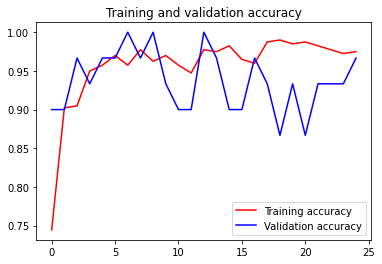

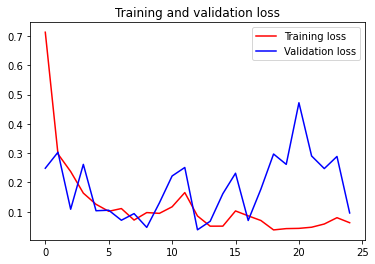

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing

Saving images(11).jpg to images(11).jpg


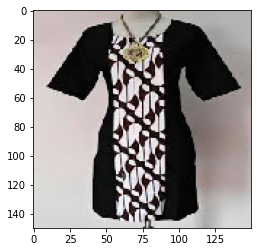

images(11).jpg
[1.1313232e-03 3.3224811e-04 2.0354248e-03 9.9606884e-01 4.3212678e-04]
Celup: 0.11%
Cendrawasih: 0.03%
Kawung: 0.20%
Parang: 99.61%
Tambal: 0.04%


In [42]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
image_labels = train_generator.class_indices.keys()
uploaded = files.upload()


for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  Classes = model2.predict(images)[0] #proba = model2.predict(images)[0]
  plt.imshow(img)
  plt.show()
  print(fn)
  print(Classes)
  for (imge, pers) in zip(image_labels, Classes):
    print("{}: {:.2f}%".format(imge, pers * 100))

## Saving model

In [ ]:
# Save model h5
model2.save("/content/batik_model.h5")

In [ ]:
# Save model pb
!mkdir -p saved_model
model2.save('content/batik_models')

In [ ]:
!zip -r 'dataa.zip' 'content/batik_models'

In [ ]:
from google.colab import files 
files.download("dataa.zip")